In [0]:
%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

from random import shuffle
import time
import copy

# We will learn across this notebook how to create from the scratch, instantiate, train and evaluate an MLP model
Previously, we learned how a perceptron works, how to train it, evaluate it and when we have a linearly separable dataset, we saw the perceptron performs very well. However, we assumed a binary classification problem but often multiclass problems appear and the perceptron can't handle them. Even in binary classification problems, we cannot assume a linearly separable behavior over the spatial distribution of the data. MLP comes to overcome these problems. As we saw in our course the MLP learns a different representation of the data aiming at turning they into linearly separable data, so a single linear separator can classify the data into 0 or 1, yes or not, sick or not sick, so on. And whether we want to classify multiclass data, we need more independent neurons on the top of the stack layers.


---



![fitting gif](https://miro.medium.com/max/2304/1*fiYPinouczFoVeB6KYqs9Q.gif)

# Before we start to classify the 10 classes in CIFAR10, let's compare the performance of a single neuron with a multi layer perceptron

In [11]:
#@title <h1>Loading the CIFAR10 dataset and turning it in grayscale</h1> ```transforms.Grayscale(num_output_channels=1)``` this line above abstracts it to us. This transforms are an execution pipeline of transformations on the data, 
#@markdown turning the images into grayscale is an way to make a dimensional reduction. Before, we had 32 `*` 32 `*` 3 independent covariants, now we have 32`*`32
#@markdown <br>If you want to use the 3 RGB channels, copy this cell into another cell and comment the line `transforms.Grayscale()`

transform=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    
])

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

target_labels = ('plane', 'car', 'ship', 'truck') 


transform_target = transforms.Lambda(lambda x: 1 if classes[x] in target_labels else 0)

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform, target_transform = transform_target)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform, target_transform = transform_target)

#@markdown ---------
test, val = random_split(dataset_test, lengths = (5000,5000))  

#@markdown ```test, val = random_split(dataset_test, lengths = (5000,5000))  ```
#@markdown this line aims to split the test dataset into to sets: validation and test

#@markdown ---
#@markdown ` transform_target` is a lambda function that will be applyed on the targets
#@markdown using target_transform argument.

Files already downloaded and verified
Files already downloaded and verified


In [0]:
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #@markdown choosing an available device

In [0]:
#@title Loading the dataloaders (better perfomance in training loop)
#@markdown ---

train_loader = DataLoader(dataset=dataset_train, shuffle=True,)
test_loader = DataLoader(dataset=test, shuffle=False)
val_loader = DataLoader(dataset=val, shuffle=False)
dataloaders = {'train': train_loader, 'val':val_loader, 'test' : test_loader }
dataset_sizes = {'train' : len(train_loader.dataset), 'test' : len(test_loader.dataset), 'val': len(val_loader.dataset)}


#@markdown ``` dataloaders = {'train': train_loader, 'val':val_loader, 'test' : test_loader }```<br>
#@markdown ```dataset_sizes = {'train' : len(train_loader.dataset), 'test' : len(test_loader.dataset), 'val': len(val_loader.dataset)}```
#@markdown <br>These lines above set two dictionaries holding train, validation and test dataloaders and sizes, respectively.

In [0]:
#@title Build your own Multi Layer Perceptron
#@markdown you can see also [pytorch's documentation](https://pytorch.org/docs/stable/nn.html) for exploit another activation functions and modules

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32, 200)
        self.fc2 = nn.Linear(200, 128)
        self.fc3 = nn.Linear(128, 2)
        self.activation_function = nn.Sigmoid()
        self.activation_function2 = nn.Tanh()
    def forward(self, x):
        #@markdown ---
        #@markdown ```x = x.view(-1, 32*32)``` this line of code linearizes the input. Remember: in MLP the input shape needs to be a N X 1 matrix
        x = x.view(-1, 32*32)
        x = self.activation_function2(self.fc1(x))
        x = self.activation_function2(self.fc2(x))
        x = self.activation_function(self.fc3(x))
        return x

In [0]:
#@title Training loop
#@markdown In the training looping the best model on evaluation phase is saved. Therefore, independly of how many epochs was set, the highest accuracy model will be returned
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              # statistics
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)
          if phase == 'train':
              scheduler.step()

          epoch_loss = running_loss / dataset_sizes[phase]
          epoch_acc = running_corrects.double() / dataset_sizes[phase]

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(
              phase, epoch_loss, epoch_acc))

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

      print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [7]:
# Avaliar o modelo aqui (no conjunto de teste)
from sklearn import metrics as mtr

def evaluate(model, data_loader):
  acc = 0.0
  model.eval()
  y_hat = []
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_hat.append(preds)
        acc += torch.sum(preds == labels.data)

  print('Acc test_set: {:.4f}'.format(acc.double()/len(data_loader.dataset)))
  Y_true = [y_true for inputs, labels in iter(data_loader) for y_true in labels.cpu().numpy()]

  Y_hat =  [label for joint in y_hat for label in joint.cpu().numpy()]
  print(mtr.classification_report(Y_true, Y_hat))
  plt.rcParams["figure.figsize"] = (10,10)
  mtr.ConfusionMatrixDisplay(mtr.confusion_matrix(Y_true, Y_hat), display_labels= classes).plot()
  plt.show()
  

In [19]:
model = MLP()
print(model)

MLP(
  (fc1): Linear(in_features=1024, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (activation_function): Sigmoid()
  (activation_function2): Tanh()
)


## Setting Hyper-parameters 

In [20]:

optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 4)
num_epochs = 10

model.to(device)

MLP(
  (fc1): Linear(in_features=1024, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (activation_function): Sigmoid()
  (activation_function2): Tanh()
)

## Training the model

In [21]:
train_model(model, criterion, optimizer, scheduler, num_epochs )

Epoch 0/9
----------
train Loss: 0.5771 Acc: 0.7213
val Loss: 0.5562 Acc: 0.7476

Epoch 1/9
----------
train Loss: 0.5521 Acc: 0.7482
val Loss: 0.5574 Acc: 0.7446

Epoch 2/9
----------
train Loss: 0.5403 Acc: 0.7624
val Loss: 0.5344 Acc: 0.7692

Epoch 3/9
----------
train Loss: 0.5347 Acc: 0.7666
val Loss: 0.5208 Acc: 0.7826

Epoch 4/9
----------
train Loss: 0.5185 Acc: 0.7851
val Loss: 0.5174 Acc: 0.7840

Epoch 5/9
----------
train Loss: 0.5157 Acc: 0.7879
val Loss: 0.5168 Acc: 0.7882

Epoch 6/9
----------
train Loss: 0.5143 Acc: 0.7896
val Loss: 0.5114 Acc: 0.7962

Epoch 7/9
----------
train Loss: 0.5126 Acc: 0.7914
val Loss: 0.5124 Acc: 0.7906

Epoch 8/9
----------
train Loss: 0.5090 Acc: 0.7955
val Loss: 0.5112 Acc: 0.7932

Epoch 9/9
----------
train Loss: 0.5085 Acc: 0.7968
val Loss: 0.5109 Acc: 0.7944

Training complete in 12m 7s
Best val Acc: 0.796200


MLP(
  (fc1): Linear(in_features=1024, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (activation_function): Sigmoid()
  (activation_function2): Tanh()
)

## Evaluating the model

Acc test_set: 0.7778
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      2974
           1       0.77      0.64      0.70      2026

    accuracy                           0.78      5000
   macro avg       0.78      0.76      0.76      5000
weighted avg       0.78      0.78      0.77      5000



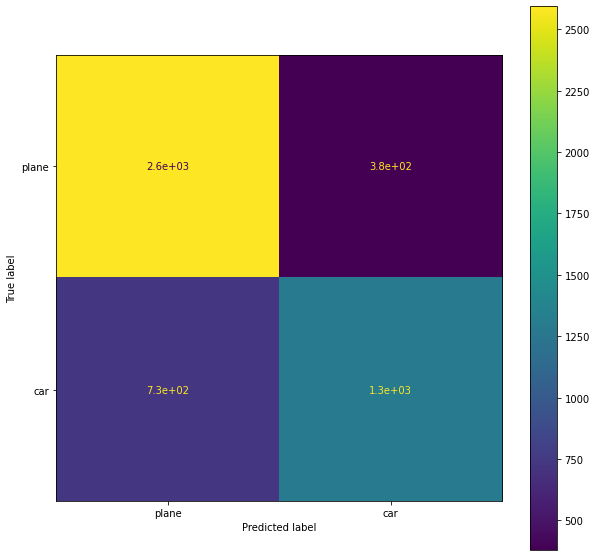

In [22]:
evaluate(model, test_loader)

# Compare the results both MLP and single perceptron and se how hierarchical stacked layers can improve the accuracy

In [43]:
#@title <h1>Loading the CIFAR10 dataset, but now with the entire class representation and RGB channels</h1> 

transform=transforms.Compose([
    transforms.ToTensor(),
    
])

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

#@markdown ---------
test, val = random_split(dataset_test, lengths = (5000,5000))  

#@markdown ```test, val = random_split(dataset_test, lengths = (5000,5000))  ```
#@markdown this line aims to split the test dataset into to sets: validation and test

Files already downloaded and verified
Files already downloaded and verified


In [0]:
#@title Loading the dataloaders (better perfomance in training loop)
#@markdown ---

train_loader = DataLoader(dataset=dataset_train, shuffle=True,)
test_loader = DataLoader(dataset=test, shuffle=False)
val_loader = DataLoader(dataset=val, shuffle=False)
dataloaders = {'train': train_loader, 'val':val_loader, 'test' : test_loader }
dataset_sizes = {'train' : len(train_loader.dataset), 'test' : len(test_loader.dataset), 'val': len(val_loader.dataset)}


#@markdown ``` dataloaders = {'train': train_loader, 'val':val_loader, 'test' : test_loader }```<br>
#@markdown ```dataset_sizes = {'train' : len(train_loader.dataset), 'test' : len(test_loader.dataset), 'val': len(val_loader.dataset)}```
#@markdown <br>These lines above set two dictionaries holding train, validation and test dataloaders and sizes, respectively.

In [0]:
#@title Build your own Multi Layer Perceptron
#@markdown you can see also [pytorch's documentation](https://pytorch.org/docs/stable/nn.html) for exploit another activation functions and modules

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 200)
        self.fc2 = nn.Linear(200, 128)
        self.fc3 = nn.Linear(128, 10)
        self.activation_function = nn.Sigmoid()
        self.activation_function2 = nn.Tanh()
    def forward(self, x):
        #@markdown ---
        #@markdown ```x = x.view(-1, 32*32*3)``` this line of code linearizes the input. Remember: in MLP the input shape needs to be a N X 1 matrix
        x = x.view(-1, 32*32*3)
        x = self.activation_function2(self.fc1(x))
        x = self.activation_function2(self.fc2(x))
        x = self.activation_function(self.fc3(x))
        return x

In [40]:
model = MLP()
print(model)

MLP(
  (fc1): Linear(in_features=3072, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (activation_function): Sigmoid()
  (activation_function2): Tanh()
)


## Setting Hyper-parameters 

In [41]:

optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 4)
num_epochs = 10

model.to(device)

MLP(
  (fc1): Linear(in_features=3072, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (activation_function): Sigmoid()
  (activation_function2): Tanh()
)

## Training the model

In [46]:
train_model(model, criterion, optimizer, scheduler, num_epochs )

Epoch 0/9
----------
train Loss: 2.0676 Acc: 0.2853
val Loss: 2.0295 Acc: 0.3320

Epoch 1/9
----------
train Loss: 1.9943 Acc: 0.3519
val Loss: 1.9667 Acc: 0.3846

Epoch 2/9
----------
train Loss: 1.9771 Acc: 0.3626
val Loss: 1.9744 Acc: 0.3508

Epoch 3/9
----------
train Loss: 1.9674 Acc: 0.3679
val Loss: 1.9559 Acc: 0.3868

Epoch 4/9
----------
train Loss: 1.9305 Acc: 0.4041
val Loss: 1.9271 Acc: 0.4072

Epoch 5/9
----------
train Loss: 1.9224 Acc: 0.4132
val Loss: 1.9217 Acc: 0.4220

Epoch 6/9
----------
train Loss: 1.9178 Acc: 0.4157
val Loss: 1.9176 Acc: 0.4236

Epoch 7/9
----------
train Loss: 1.9135 Acc: 0.4201
val Loss: 1.9156 Acc: 0.4240

Epoch 8/9
----------
train Loss: 1.9068 Acc: 0.4264
val Loss: 1.9119 Acc: 0.4294

Epoch 9/9
----------
train Loss: 1.9057 Acc: 0.4292
val Loss: 1.9113 Acc: 0.4266

Training complete in 19m 4s
Best val Acc: 0.429400


MLP(
  (fc1): Linear(in_features=3072, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (activation_function): Sigmoid()
  (activation_function2): Tanh()
)

## Evaluating the model

Acc test_set: 0.4240
              precision    recall  f1-score   support

           0       0.46      0.40      0.43       509
           1       0.52      0.44      0.48       496
           2       0.29      0.28      0.29       500
           3       0.30      0.38      0.34       488
           4       0.39      0.26      0.31       480
           5       0.42      0.30      0.35       520
           6       0.42      0.50      0.46       503
           7       0.48      0.53      0.51       511
           8       0.49      0.57      0.53       498
           9       0.45      0.56      0.50       495

    accuracy                           0.42      5000
   macro avg       0.42      0.42      0.42      5000
weighted avg       0.42      0.42      0.42      5000



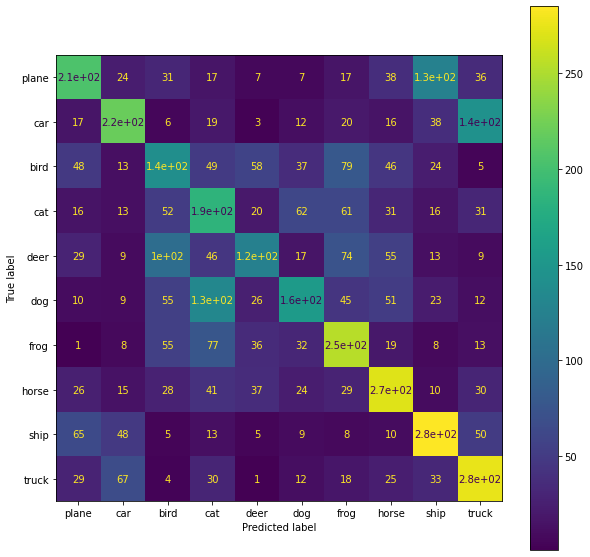

In [47]:
evaluate(model, test_loader)

## Saving the model in your drive

In [0]:
from google.colab import drive
drive.mount('content/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at content/


In [0]:
model_save_name = "first_model.pt" #@param {type:"string"}
drive_path = "DNN/" #@param {type:"string"}
path = F"/content/content/My Drive/{drive_path}{model_save_name}" 
print(path)
torch.save(model.state_dict(), path)

## Loading the saved model

In [0]:
model = MLP() #@markdown Instantiate a mlp object

In [0]:
model_save_name = 'first_model.pt' #@param {type:"string"}
drive_path = "DNN/" #@param {type:"string"}
path = F"/content/content/My Drive/{drive_path}{model_save_name}" 
model.load_state_dict(torch.load(path))

<All keys matched successfully>

## Evaluate the loaded model

Acc test_set: 0.3594
              precision    recall  f1-score   support

           0       0.41      0.28      0.33       503
           1       0.38      0.36      0.37       465
           2       0.27      0.29      0.28       489
           3       0.30      0.18      0.22       516
           4       0.30      0.30      0.30       490
           5       0.31      0.27      0.29       498
           6       0.34      0.43      0.38       531
           7       0.41      0.42      0.42       513
           8       0.42      0.53      0.47       504
           9       0.42      0.52      0.47       491

    accuracy                           0.36      5000
   macro avg       0.36      0.36      0.35      5000
weighted avg       0.36      0.36      0.35      5000



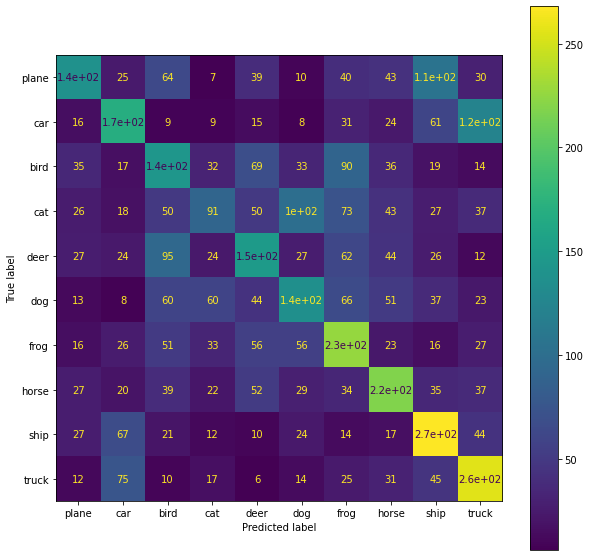

In [0]:
model.to(device)
evaluate(model, dataloaders['test'])


## Grid-search: a brute force search on hyper-parameters
 **<h1><center>CAUTION</center></h1>** 
This cell is a grid-search template. Only run it if you have set all the scenarios you want to explore and put in mind that it will cost a lot of time 

Epoch 0/0
----------
train Loss: 2.3045 Acc: 0.0978
val Loss: 2.3026 Acc: 0.1088

Training complete in 1m 20s
Best val Acc: 0.108800
Acc test_set: 0.1088


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       481
           1       0.11      1.00      0.20       544
           2       0.00      0.00      0.00       485
           3       0.00      0.00      0.00       492
           4       0.00      0.00      0.00       500
           5       0.00      0.00      0.00       482
           6       0.00      0.00      0.00       494
           7       0.00      0.00      0.00       485
           8       0.00      0.00      0.00       528
           9       0.00      0.00      0.00       509

    accuracy                           0.11      5000
   macro avg       0.01      0.10      0.02      5000
weighted avg       0.01      0.11      0.02      5000



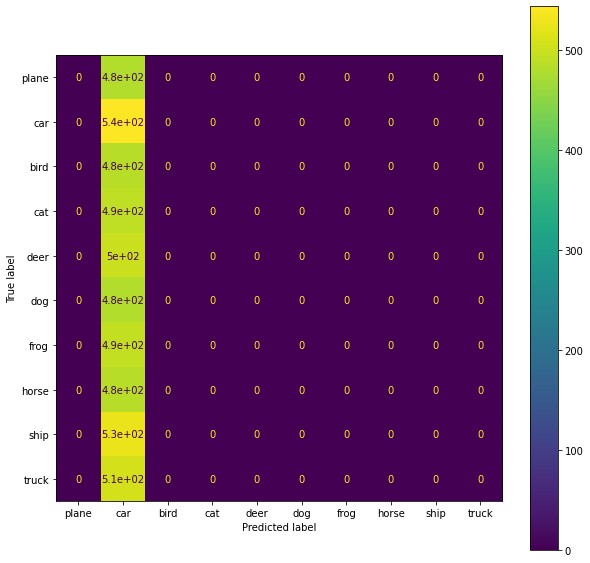

/content/content/My Drive/DNN/1_0.01_SGD_CEL_SLR.pt
Epoch 0/0
----------
train Loss: 2.3027 Acc: 0.0978
val Loss: 2.3026 Acc: 0.1018

Training complete in 1m 21s
Best val Acc: 0.101800
Acc test_set: 0.1018
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       481
           1       0.00      0.00      0.00       544
           2       0.00      0.00      0.00       485
           3       0.00      0.00      0.00       492
           4       0.00      0.00      0.00       500
           5       0.00      0.00      0.00       482
           6       0.00      0.00      0.00       494
           7       0.00      0.00      0.00       485
           8       0.00      0.00      0.00       528
           9       0.10      1.00      0.18       509

    accuracy                           0.10      5000
   macro avg       0.01      0.10      0.02      5000
weighted avg       0.01      0.10      0.02      5000



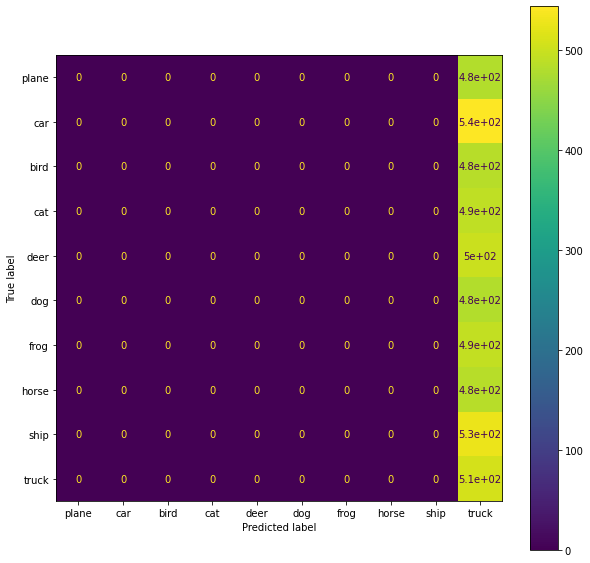

/content/content/My Drive/DNN/1_0.001_SGD_CEL_SLR.pt
Epoch 0/0
----------
train Loss: 2.3027 Acc: 0.0976
val Loss: 2.3025 Acc: 0.1088

Training complete in 1m 21s
Best val Acc: 0.108800
Acc test_set: 0.1088
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       481
           1       0.11      1.00      0.20       544
           2       0.00      0.00      0.00       485
           3       0.00      0.00      0.00       492
           4       0.00      0.00      0.00       500
           5       0.00      0.00      0.00       482
           6       0.00      0.00      0.00       494
           7       0.00      0.00      0.00       485
           8       0.00      0.00      0.00       528
           9       0.00      0.00      0.00       509

    accuracy                           0.11      5000
   macro avg       0.01      0.10      0.02      5000
weighted avg       0.01      0.11      0.02      5000



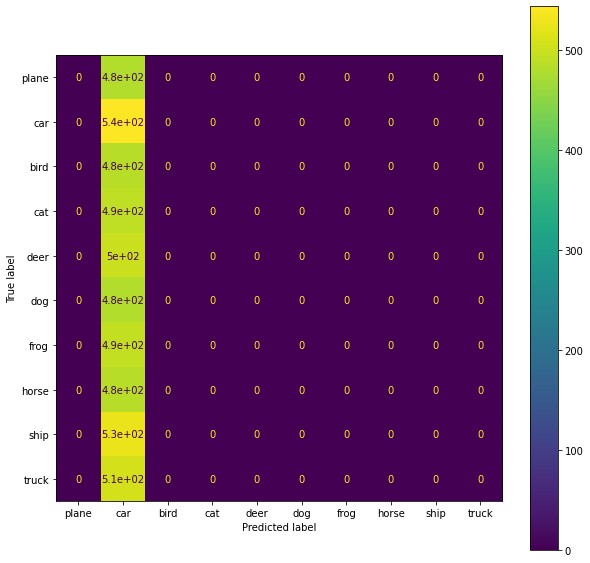

/content/content/My Drive/DNN/1_0.0001_SGD_CEL_SLR.pt
Epoch 0/0
----------
train Loss: 2.3026 Acc: 0.0975
val Loss: 2.3025 Acc: 0.1088

Training complete in 1m 23s
Best val Acc: 0.108800
Acc test_set: 0.1088
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       481
           1       0.11      1.00      0.20       544
           2       0.00      0.00      0.00       485
           3       0.00      0.00      0.00       492
           4       0.00      0.00      0.00       500
           5       0.00      0.00      0.00       482
           6       0.00      0.00      0.00       494
           7       0.00      0.00      0.00       485
           8       0.00      0.00      0.00       528
           9       0.00      0.00      0.00       509

    accuracy                           0.11      5000
   macro avg       0.01      0.10      0.02      5000
weighted avg       0.01      0.11      0.02      5000



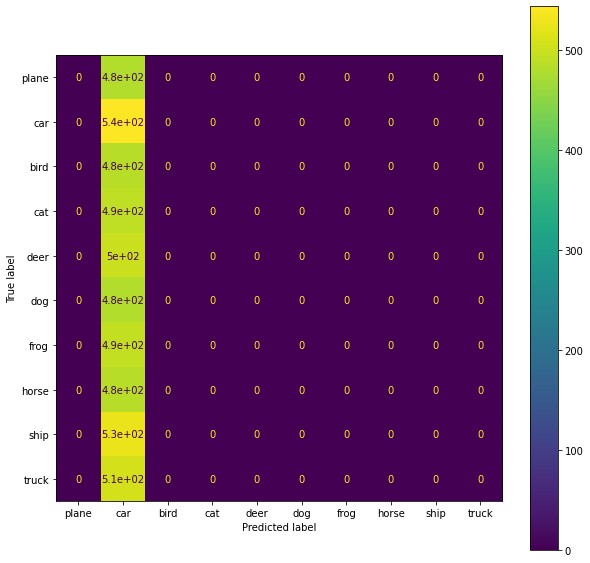

/content/content/My Drive/DNN/1_1e-05_SGD_CEL_SLR.pt
Epoch 0/9
----------
train Loss: 2.3026 Acc: 0.0996
val Loss: 2.3026 Acc: 0.0970

Epoch 1/9
----------
train Loss: 2.3026 Acc: 0.1001
val Loss: 2.3026 Acc: 0.0970

Epoch 2/9
----------
train Loss: 2.3026 Acc: 0.0991
val Loss: 2.3026 Acc: 0.0970

Epoch 3/9
----------
train Loss: 2.3026 Acc: 0.0987
val Loss: 2.3026 Acc: 0.0970

Epoch 4/9
----------
train Loss: 2.3026 Acc: 0.1000
val Loss: 2.3026 Acc: 0.0970

Epoch 5/9
----------
train Loss: 2.3026 Acc: 0.1000
val Loss: 2.3026 Acc: 0.0970

Epoch 6/9
----------
train Loss: 2.3026 Acc: 0.1000
val Loss: 2.3026 Acc: 0.0970

Epoch 7/9
----------
train Loss: 2.3026 Acc: 0.1000
val Loss: 2.3026 Acc: 0.0970

Epoch 8/9
----------
train Loss: 2.3026 Acc: 0.1000
val Loss: 2.3026 Acc: 0.0970

Epoch 9/9
----------
train Loss: 2.3026 Acc: 0.1000
val Loss: 2.3026 Acc: 0.0970

Training complete in 13m 47s
Best val Acc: 0.097000
Acc test_set: 0.0970
              precision    recall  f1-score   support


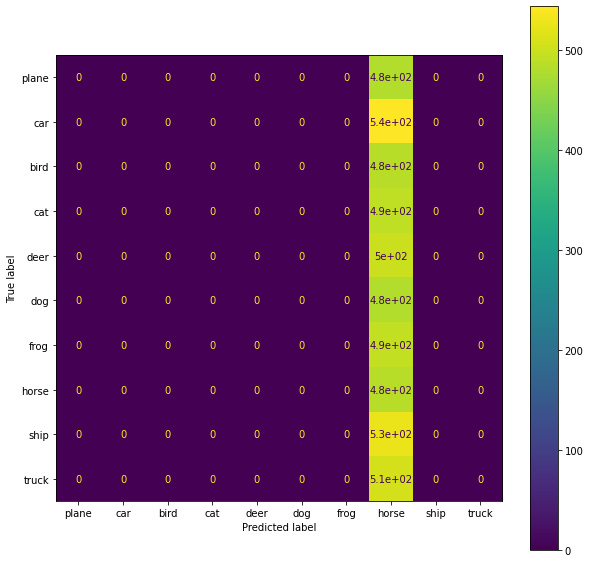

/content/content/My Drive/DNN/10_0.01_SGD_CEL_SLR.pt
Epoch 0/9
----------
train Loss: 2.3026 Acc: 0.0958
val Loss: 2.3026 Acc: 0.0970

Epoch 1/9
----------
train Loss: 2.3026 Acc: 0.0965
val Loss: 2.3026 Acc: 0.0970

Epoch 2/9
----------
train Loss: 2.3026 Acc: 0.0965
val Loss: 2.3026 Acc: 0.0970

Epoch 3/9
----------
train Loss: 2.3026 Acc: 0.0981
val Loss: 2.3026 Acc: 0.0970

Epoch 4/9
----------
train Loss: 2.3026 Acc: 0.0991
val Loss: 2.3026 Acc: 0.0970

Epoch 5/9
----------
train Loss: 2.3026 Acc: 0.0995
val Loss: 2.3026 Acc: 0.0970

Epoch 6/9
----------
train Loss: 2.3026 Acc: 0.0994
val Loss: 2.3026 Acc: 0.0970

Epoch 7/9
----------
train Loss: 2.3026 Acc: 0.0990
val Loss: 2.3026 Acc: 0.0970

Epoch 8/9
----------
train Loss: 2.3026 Acc: 0.1000
val Loss: 2.3026 Acc: 0.0970

Epoch 9/9
----------
train Loss: 2.3026 Acc: 0.1000
val Loss: 2.3026 Acc: 0.0970

Training complete in 13m 56s
Best val Acc: 0.097000
Acc test_set: 0.0970
              precision    recall  f1-score   support


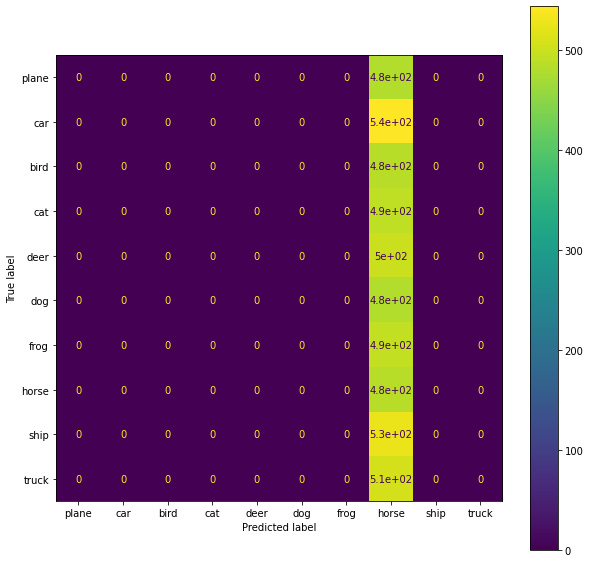

/content/content/My Drive/DNN/10_0.001_SGD_CEL_SLR.pt
Epoch 0/9
----------
train Loss: 2.3026 Acc: 0.0960
val Loss: 2.3026 Acc: 0.0988

Epoch 1/9
----------
train Loss: 2.3026 Acc: 0.0986
val Loss: 2.3026 Acc: 0.0970

Epoch 2/9
----------
train Loss: 2.3026 Acc: 0.0983
val Loss: 2.3026 Acc: 0.1112

Epoch 3/9
----------
train Loss: 2.3026 Acc: 0.0977
val Loss: 2.3026 Acc: 0.0970

Epoch 4/9
----------
train Loss: 2.3026 Acc: 0.0986
val Loss: 2.3026 Acc: 0.0970

Epoch 5/9
----------
train Loss: 2.3026 Acc: 0.0998
val Loss: 2.3026 Acc: 0.0970

Epoch 6/9
----------
train Loss: 2.3026 Acc: 0.1000
val Loss: 2.3026 Acc: 0.0970

Epoch 7/9
----------
train Loss: 2.3026 Acc: 0.1000
val Loss: 2.3026 Acc: 0.0970

Epoch 8/9
----------
train Loss: 2.3026 Acc: 0.1000
val Loss: 2.3026 Acc: 0.0970

Epoch 9/9
----------
train Loss: 2.3026 Acc: 0.1000
val Loss: 2.3026 Acc: 0.0970

Training complete in 13m 49s
Best val Acc: 0.111200
Acc test_set: 0.1112
              precision    recall  f1-score   support

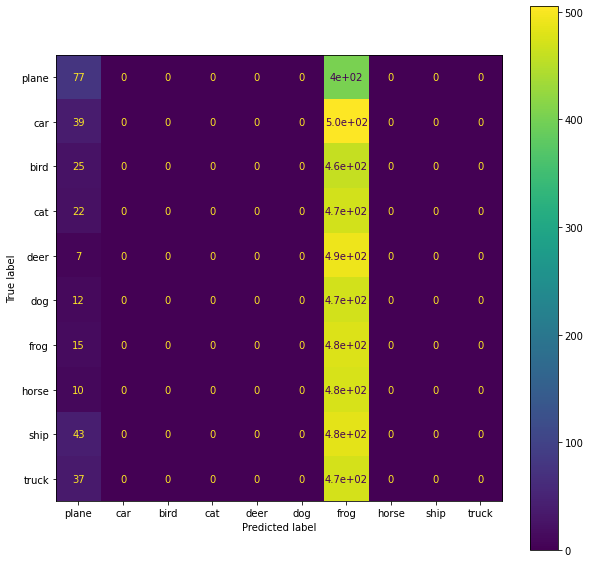

/content/content/My Drive/DNN/10_0.0001_SGD_CEL_SLR.pt
Epoch 0/9
----------
train Loss: 2.3026 Acc: 0.0975
val Loss: 2.3026 Acc: 0.1000

Epoch 1/9
----------
train Loss: 2.3026 Acc: 0.0969
val Loss: 2.3026 Acc: 0.1286

Epoch 2/9
----------
train Loss: 2.3026 Acc: 0.0980
val Loss: 2.3026 Acc: 0.0970

Epoch 3/9
----------
train Loss: 2.3026 Acc: 0.0970
val Loss: 2.3026 Acc: 0.0970

Epoch 4/9
----------
train Loss: 2.3026 Acc: 0.1001
val Loss: 2.3026 Acc: 0.0970

Epoch 5/9
----------
train Loss: 2.3026 Acc: 0.1009
val Loss: 2.3026 Acc: 0.0970

Epoch 6/9
----------
train Loss: 2.3026 Acc: 0.1012
val Loss: 2.3026 Acc: 0.0970

Epoch 7/9
----------
train Loss: 2.3026 Acc: 0.0999
val Loss: 2.3026 Acc: 0.0970

Epoch 8/9
----------
train Loss: 2.3026 Acc: 0.1000
val Loss: 2.3026 Acc: 0.0970

Epoch 9/9
----------
train Loss: 2.3026 Acc: 0.1000
val Loss: 2.3026 Acc: 0.0970

Training complete in 13m 54s
Best val Acc: 0.128600
Acc test_set: 0.1286
              precision    recall  f1-score   suppor

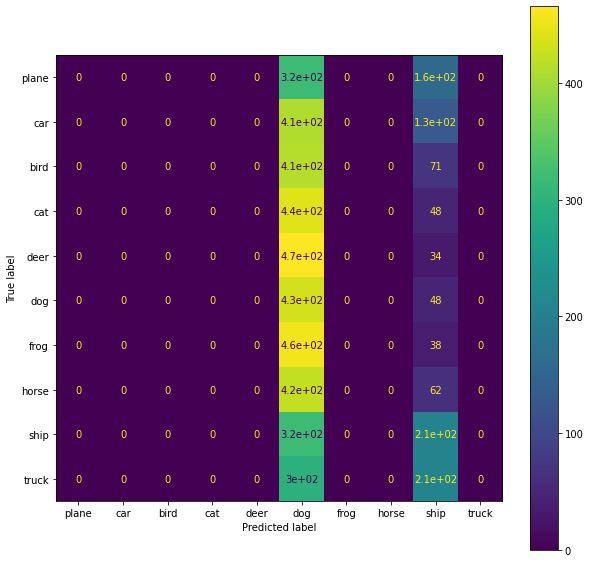

/content/content/My Drive/DNN/10_1e-05_SGD_CEL_SLR.pt
Epoch 0/99
----------
train Loss: 2.3026 Acc: 0.0983
val Loss: 2.3026 Acc: 0.1056

Epoch 1/99
----------
train Loss: 2.3026 Acc: 0.0986
val Loss: 2.3026 Acc: 0.1056

Epoch 2/99
----------
train Loss: 2.3026 Acc: 0.0975
val Loss: 2.3026 Acc: 0.0970

Epoch 3/99
----------
train Loss: 2.3026 Acc: 0.0976
val Loss: 2.3026 Acc: 0.0970

Epoch 4/99
----------
train Loss: 2.3026 Acc: 0.1000
val Loss: 2.3026 Acc: 0.0970

Epoch 5/99
----------
train Loss: 2.3026 Acc: 0.1000
val Loss: 2.3026 Acc: 0.0970

Epoch 6/99
----------
train Loss: 2.3026 Acc: 0.1004
val Loss: 2.3026 Acc: 0.0970

Epoch 7/99
----------
train Loss: 2.3026 Acc: 0.1000
val Loss: 2.3026 Acc: 0.0970

Epoch 8/99
----------
train Loss: 2.3026 Acc: 0.1000
val Loss: 2.3026 Acc: 0.0970

Epoch 9/99
----------
train Loss: 2.3026 Acc: 0.1000
val Loss: 2.3026 Acc: 0.0970

Epoch 10/99
----------
train Loss: 2.3026 Acc: 0.1000
val Loss: 2.3026 Acc: 0.0970

Epoch 11/99
----------
train Los

In [0]:
epochs = [1, 10, 100, 1000]
learning_rate = [1e-2, 1e-3, 1e-4, 1e-5]
model_list = [nn.Sequential(nn.Flatten(),
                      nn.Linear(32*32, 300), 
                      nn.Sigmoid(), 
                      nn.Linear(300, 200), 
                      nn.Sigmoid(), 
                      nn.Linear(200, 200),
                      nn.Sigmoid(),
                      nn.Linear(200, 10),
                      nn.Sigmoid()),
              
              nn.Sequential(nn.Flatten(),
                      nn.Linear(32*32, 300), 
                      nn.Tanh(), 
                      nn.Linear(300, 200), 
                      nn.Tanh(), 
                      nn.Linear(200, 200),
                      nn.Tanh(),
                      nn.Linear(200, 10),
                      nn.LogSoftmax())]
            
for models in model_list: 
  for num_epochs in epochs:
    for lr in learning_rate:
      
      
      model = models
      
      optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
      criterion = torch.nn.CrossEntropyLoss()
      scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 4)
      model.to(device)
      
      model_fitted = train_model(model, criterion, optimizer, scheduler, num_epochs )
      
      evaluate(model_fitted, dataloaders['val'])
      model_save_name = F"{num_epochs}_{lr}_SGD_CEL_SLR.pt"
      drive_path = "DNN/" 
      path = F"/content/content/My Drive/{drive_path}{model_save_name}" 
      print(path)
      torch.save(model_fitted.state_dict(), path)


# Now it is your turn to implement your own classifier